# Assignment: Linear and logistic regression

## Objectives

The objectives of this assignment are:
1. to learn to use linear regression for predicting continuously varying target variables
2. to learn to use logistic regression for binary classification
3. to learn to estimate the relative importance of input features

## Setup

In this assignment, use the Real Estate Valuation dataset that is available at [https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set](https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set). The data is collected from New Taipei City, Taiwan.

## Task

The assignment consists of constructing *two* separate models for predicting the real estate prices in the dataset: one with linear and one with logistic regression.

1. **Linear regression model**: construct a linear regression model for predicting the continuous target variable "Y house price of unit area" in the dataset.

2. **Logistic regression model**: convert the target variable into a binary-valued one according to whether the original target value is above or below the average house price of unit area (within the training set samples), and construct a binary classifier for predicting its value with logistic regression.

Both models should be validated, with appropriate metrics presented and discussed.

Remember to draw conclusions from your results and interpret your findings! Can you e.g. estimate which of the input variables has the most important role when predicting the house prices, and which ones are less important? Also, give some thought to whether the input data should be standardized before modeling or not.

Prepare a Jupyter notebook containing a full account of the problem treatment. Construct your notebook to include sections for each of the six separate stages in the CRISP-DM model, with appropriate contents (include subsections for the two separate tasks in "Modeling" and "Evaluation").

## Deliverables

Submit a GitHub permalink that points to the Jupyter notebook as instructed in Oma. The submitted notebook must contain the problem analysis written in accordance with the CRISP-DM process model, complete with Markdown blocks and comments that clearly explain what has been done.


In [231]:
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt

# Preparing the data

# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

# data (as pandas dataframes)
X = real_estate_valuation.data.features
y = real_estate_valuation.data.targets

# inputs
df = pd.DataFrame(X, columns=real_estate_valuation.data.feature_names)
df.columns = ['TransactionDate', 'HouseAge', 'DistanceToMRT', 'NumOfConvenienceStores', 'Latitude', 'Longitude']


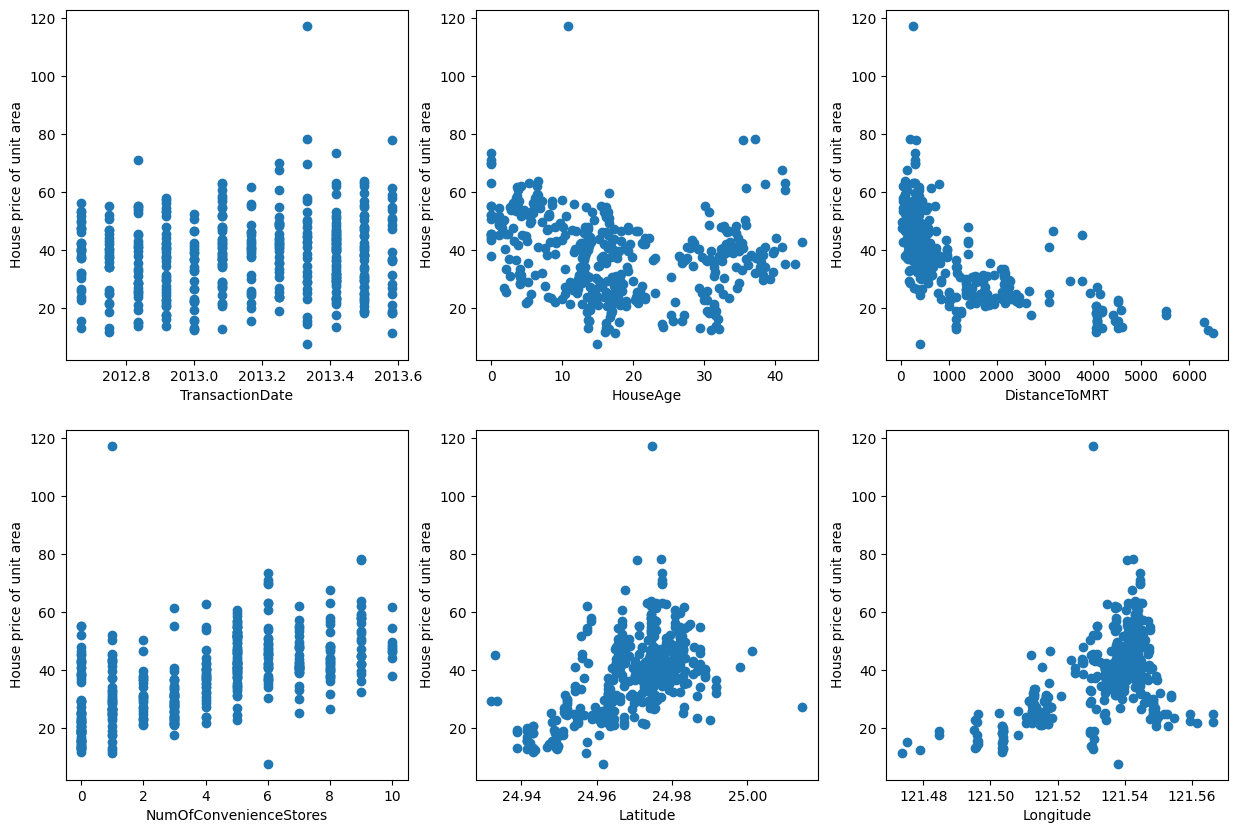

In [232]:
# check relationships between columns and price

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for index, column in enumerate(df.columns):
    axes[index].scatter(df[column], y)
    axes[index].set_xlabel(column)
    axes[index].set_ylabel('House price of unit area')

## Testing the model without standardizing the data

In [233]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the house prices on the test set
preds = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
formatted_coefficients = ', '.join([f'{coef:.5f}' for coef in model.coef_[0]])
print("Coefficients: ", formatted_coefficients)
print("Intercept: ", model.intercept_)

Mean Squared Error: 53.50561912450505
Mean Absolute Error: 5.305355690074272
Coefficients:  5.44074, -0.27079, -0.00476, 1.09143, 229.04305, -29.49259
Intercept:  [-13044.23191716]


## Standardize the data and test again

In [234]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(X), columns=df.columns)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the house prices on the test set
preds = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
formatted_coefficients = ', '.join([f'{coef:.5f}' for coef in model.coef_[0]])
print("Coefficients: ", formatted_coefficients)
print("Intercept: ", model.intercept_)

# mitä tällä saavutettiin? (lol)

Mean Squared Error: 53.505619124502054
Mean Absolute Error: 5.305355690074042
Coefficients:  1.53226, -3.08126, -5.99867, 3.21098, 2.83903, -0.45208
Intercept:  [37.95545287]


## Logistic regression

In [235]:
from sklearn.linear_model import LogisticRegression

# Convert target variable to binary: 1 if above average, 0 if below
y_binary = (y > y.mean()).astype(int).values.ravel()

X_train, X_test, y_train, y_test = train_test_split(df, y_binary, test_size=0.2, random_state=42)

reg = LogisticRegression()
reg.fit(X_train, y_train)

print("Coefficients: ",reg.coef_)
print("Intercept: ", reg.intercept_)

Coefficients:  [[ 0.25737881 -0.56553588 -2.2777809   0.63362583  1.02692729 -0.07436174]]
Intercept:  [-0.51630777]


### Cross-validation

Accuracy: 0.83
Confusion Matrix:
 [[153  47]
 [ 25 189]]


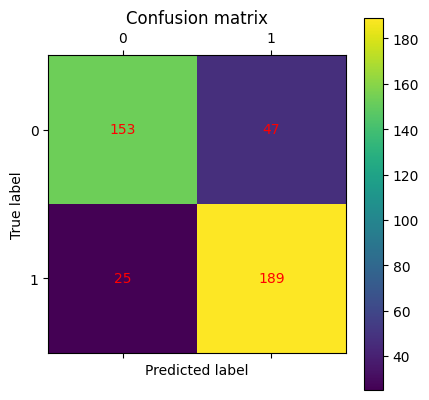

In [238]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = cross_val_predict(estimator=reg, X=df, y=y_binary, cv=10)

cm = confusion_matrix(y_binary, y_pred)
accuracy = accuracy_score(y_binary, y_pred)

print("Accuracy: %0.2f" % accuracy)
print("Confusion Matrix:\n", cm)

# visualize confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# include counts
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

### Estimating feature importance with permutation importance

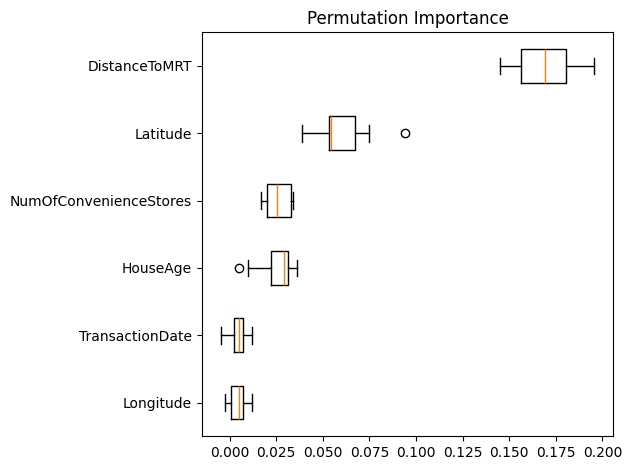

In [239]:
# feature importance
from sklearn.inspection import permutation_importance

result = permutation_importance(reg, df, y_binary, n_repeats=10, scoring="accuracy", random_state=0, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=df.columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()